In [ ]:

def w_next(u, v, w, eta):
    """
    Function for evolution of w 

    Parameters:
    u (Double)
    v (Double)
    w (Double)
    eta (Double)

    Returns :
    Next iteration of w
    """

    if v == 0:
        if eta == 1:
            return (u ** 2) / (1 + w ** 2)
        return eta * (u ** 2) / (1 + w ** 2) + (1 - eta) * (u ** 2) / (1 - w ** 2)

    x1 = (eta * (u ** 2 - v ** 2)) / (1 + w ** 2)

    if eta == 1:
        # print("asdfkj")
        return x1

    y1 = (u ** 2 + v ** 2) * (1 - eta) / (1 - w ** 2)
    # y1 = 0
    return x1 + y1


def v_next(u, v, w, eta):
    """
    Function for evolution of w

    Parameters:
    u (Double)
    v (Double)
    w (Double)
    eta (Double)

    Returns :
    Next iteration of v
    """
    if v == 0:
        return 0
    return (-2 * u * v * eta) / (1 + w ** 2)


def u_next(u, v, w, eta):
    """
    Function for evolution of w

    Parameters:
    u (Double)
    v (Double)
    w (Double)
    eta (Double)

    Returns :
    Next iteration of u
    """
    return 2 * w * eta / (1 + w ** 2)


def forward(u, v, w, eta, itr=1, print_itr=False):
    """
    Function for evolution of u,v,w

    Parameters:
    u (Double)
    v (Double)
    w (Double)
    eta (Double)
    itr (int) : Number of iterations, Default : 1
    print_itr (bool) : Prints each iteration, Default : False

    Returns :
    Tuple containing next iteration of u,v,w
    """

    for _ in range(itr):
        U, V, W = u_next(u, v, w, eta), v_next(u, v, w, eta), w_next(u, v, w, eta)
        u, v, w = U, V, W
        if print_itr:
            print(u, v, w)
    return u, v, w

def StereographicProjection(xx, yy, P):
    u = 2 * ((2 * P - 1) ** 0.5) * xx / (xx ** 2 + yy ** 2 + 1)
    v = 2 * ((2 * P - 1) ** 0.5) * yy / (xx ** 2 + yy ** 2 + 1)
    w = 2 * ((2 * P - 1) ** 0.5) / (xx ** 2 + yy ** 2 + 1) - (2 * P - 1) ** 0.5
    return u,v,w


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import warnings
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
import math




def zero_one(a):
    if a < 2:
        return 0
    else:
        return 1


def cover(I, scale):

    N, M = I.shape
    m1 = ratio*scale
    m2 = scale

    number_of_boxes = 1
    X = np.arange(1, N - 1, scale)
    for x in X:
        for y in X:
            r = I[
                int(x) : int(min(x + ratio*scale, N - 1)), int(y) : int(min(y + scale, M - 1))
            ]
            number_of_boxes += zero_one(len(np.unique(r)))

    return number_of_boxes


def BOX_DIMENSION(I, P, lower_dim,higher_dim):

    I = np.array(I)
    N, M = I.shape


    scales = np.linspace(lower_dim, higher_dim, 20)

    Numbers_of_boxes = []

    for scale in scales:

        number_of_boxes = cover(I, scale)
        Numbers_of_boxes.append(number_of_boxes)

    coeffs, cov = np.polyfit(np.log2(scales), np.log2(Numbers_of_boxes), 1, cov=True)
    return  [-np.round(coeffs[0], decimals=3), np.round(np.abs(coeffs[0] * np.sqrt(cov[0][0])), decimals=3)]
    


def forw(u, v, w,eta,cu,cw):
    for itr in range(100):
        # delta = np.random.normal(scale = 0.001)
        u, v, w = forward(u, v, w, eta)
        if itr > 10 and itr % 2 == 1:
            if abs(u - cu) < 0.01 and abs(w) < 0.01 and abs(v) < 0.01:
                return 2
            if abs(w - cw) < 0.01 and abs(u) < 0.01 and abs(v) < 0.01:
                return 1

            if abs(w) < 0.01 and abs(u) < 0.01:
                return 3
    return 1
    # print(u, v, w)


def compute_Z(xx, yy,eta):
    Z = []
    u,v,w = 0.9,0,0
    for _ in range(100):
      u,v,w = forward(u,v,w,eta)
      u1,v1,w1 = forward(u,v,w,eta)

    if u >0.9:
      cu = u 
      cw = w1
    else:
      cw = w
      cu = u1
    
    for row in range(len(xx)):
        Z_row = []
        for col in range(len(xx)):
            u, v, w = StereographicProjection(xx[row][col], yy[row][col], P)
            Z_row.append(forw(u, v, w,eta,cu,cw))
        Z.append(Z_row)
    return Z





def boundary(x_min, x_max, y_min, y_max, itr, P,eta):
    
    # print(x_min, x_max, y_min, y_max)
    if itr == 6:
      return 

    mid_x = (x_min) + (x_max - x_min) / 2
    mid_y = y_min + (y_max - y_min) / 2

    xx, yy = np.meshgrid(np.linspace(x_min, mid_x, 400), np.linspace(y_min, mid_y, 400))
    Z11 = compute_Z(xx, yy,eta)
    Z11_dimension = BOX_DIMENSION(Z11, P)

    xx, yy = np.meshgrid(np.linspace(mid_x, x_max, 400), np.linspace(y_min, mid_y, 400))
    Z12 = compute_Z(xx, yy,eta)
    Z12_dimension = BOX_DIMENSION(Z12, P)

    l = np.max([Z12_dimension, Z11_dimension])
    itr += 1

    print(l)

    if Z11_dimension == l:
        xx, yy = np.meshgrid(np.linspace(x_min, mid_x, 200), np.linspace(y_min, mid_y, 200))
        Z11 = compute_Z(xx, yy,eta)
        Z11_dimension = BOX_DIMENSION(Z11, P)
        print(Z11_dimension)
        if itr == 6:
            return
        boundary(x_min, mid_x, y_min, mid_y, itr, P,eta)
        

    if Z12_dimension == l:
        xx, yy = np.meshgrid(np.linspace(mid_x, x_max, 1600), np.linspace(y_min, mid_y, 1600))
        Z12 = compute_Z(xx, yy,eta)
        Z12_dimension = BOX_DIMENSION(Z12, P)
        print(Z12_dimension)
        if itr == 6:
            return
        boundary(mid_x, x_max, y_min, mid_y, itr, P,eta)
    return 



In [ ]:
def compute_Z_rot(xx, yy,x_min,x_max,y_min,y_max,eta,rad):
    Z = []
    rad = rad * np.pi/180

    u,v,w = 0.9,0,0
    for _ in range(100):
      u,v,w = forward(u,v,w,eta)
      u1,v1,w1 = forward(u,v,w,eta)

    if u >0.9:
      cu = u 
      cw = w1
    else:
      cw = w
      cu = u1
    
    for row in range(len(xx)):
        Z_row = []
        for col in range(len(xx[row])):

            PHI = xx[row][col]          
            THETA = yy[row][col]

            
            # x_mid = x_min + (x_max - x_min)/2
            # y_mid = y_min + (y_max - y_min)/2

            # t_new = THETA - x_min
            # p_new = PHI - y_min
            
            # t_rot = t_new* np.cos(rad) + p_new*np.sin(rad)
            # p_rot = -t_new*np.sin(rad) + p_new*np.cos(rad)

            # # # x_n = t_rot*np.cos(rad) - p_rot*np.sin(rad)
            # # # y_n = t_rot*np.sin(rad) + p_rot*np.cos(rad)



            # # # THETA = t_rot + x_mid
            # # # PHI = p_rot + y_mid
            # THETA = t_rot + x_min
            # PHI = p_rot + y_min

            w = (2 * P - 1) ** 0.5 * np.cos(THETA)
            v = (2 * P - 1) ** 0.5 * np.sin(THETA) * np.sin(PHI)
            u = (2 * P - 1) ** 0.5 * np.sin(THETA) * np.cos(PHI)
            # u,v,w = StereographicProjection(THETA,PHI,P)
            # print(THETA,PHI)
            Z_row.append(forw(u, v, w,eta,cu,cw))
        Z.append(Z_row)
    return Z





2.151 2.155 1

P ==  1
ETA ==  0.98125
2.2712416809618308 2.272661277007989
RATIO =  5
THETA = [2.151,2.155] 
 PHI = [-0.010000000000000009,0.010000000000000009]
DIM == 3000x600
lower box range = 6.0x85.714 BOX DIMENSION =  1.387 ERROR =  0.058
lower box range = 6.0x75.0 BOX DIMENSION =  1.347 ERROR =  0.054
lower box range = 6.0x66.667 BOX DIMENSION =  1.309 ERROR =  0.044
lower box range = 6.0x60.0 BOX DIMENSION =  1.27 ERROR =  0.037
lower box range = 6.0x54.545 BOX DIMENSION =  1.237 ERROR =  0.03
lower box range = 6.0x50.0 BOX DIMENSION =  1.223 ERROR =  0.026
lower box range = 6.0x46.154 BOX DIMENSION =  1.198 ERROR =  0.023
lower box range = 6.0x42.857 BOX DIMENSION =  1.178 ERROR =  0.019
lower box range = 6.0x40.0 BOX DIMENSION =  1.166 ERROR =  0.017
lower box range = 6.0x37.5 BOX DIMENSION =  1.158 ERROR =  0.014
lower box range = 6.0x35.294 BOX DIMENSION =  1.152 ERROR =  0.014
lower box range = 6.0x33.333 BOX DIMENSION =  1.147 ERROR =  0.013
lower box range = 6.0x31.579 B

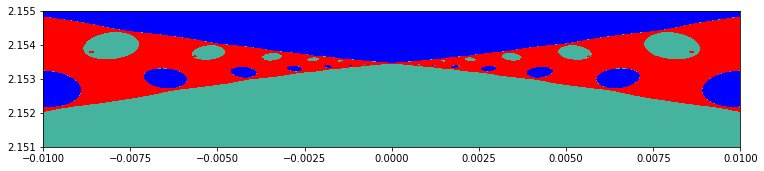

<Figure size 432x288 with 0 Axes>

In [ ]:
eta = 0.98125
P = 1
dim = 600
l1 =[
    #  [1.818359375,1.819335937,0.94],
    #  [1.796875,1.7978515625,0.9],
    #  [1.791015625,1.7919921875,0.89],
      [1.7861328125,1.787109375,0.88]]

# x_min,x_max,y_min,y_max = 0,np.pi/2,0,2
# for eta in [0.9825,0.9825,0.98375,0.985,0.98625,0.9875,0.98825,0.99,0.99125,0.9925,0.99375,0.995,0.99625,0.9975,0.99825,1]:
# for eta in [0.98125,1]:
# for _ in [1]:

for x_min,x_max,P in [[2.151,2.155,1]]:
# for P in [0.80,1]:
  print(x_min,x_max,P)
  # P = x/100
  print("========================\n")
  print( "P == ",P)
  print( "ETA == ",eta)

  u1,v1,w1 = StereographicProjection(x_min,0,P)
  x1 = math.acos( w1/ (2 * P - 1) ** 0.5)

  u2,v2,w2 = StereographicProjection(x_max,0,P)
  x2 = math.acos( w2/ (2 * P - 1) ** 0.5)

  # theta_1 = -(x2-x1)/2 + x1
  # theta_2 = (x2-x1)/2 + x1
  # theta_1 = x1
  # theta_2 = x2
  theta_1 = x_min
  theta_2 = x_max
  print(x1,x2)
  ratio = 5 
  phi_1 = -ratio*(theta_2-theta_1)/2
  phi_2 = ratio*(theta_2-theta_1)/2

  # theta_1 = 2.130
  # theta_1 = 2.115 + (P-.90)*100* (0.050)/20
  # theta_2 = 2.135 + (P-.90)*100* (0.050)/20
  # theta_2 = 2.135
  # phi_2 = 0.01

  # ratio = int(round((phi_2 - phi_1)/(theta_2-theta_1),0))
  print("RATIO = ",ratio)

  print("THETA = [{},{}] \n PHI = [{},{}]".format(theta_1,theta_2,phi_1,phi_2))

  print("DIM == {}x{}".format(ratio*dim,dim))

  xx, yy = np.meshgrid(
      np.linspace(phi_1,phi_2, ratio*dim),
      np.linspace(theta_1,theta_2, dim)
  )



  for degree in [0]:
    dd = compute_Z_rot(xx, yy,x_min,x_max,0,0,eta,degree)
    for x in range(7,25):
      dim_min = dim/100
      dim_max = dim/x
      dd_dimension,error = BOX_DIMENSION(dd, P,dim_min,dim_max)
      print("lower box range = {}x{}".format(dim_min,round(dim_max,3)),"BOX DIMENSION = ",dd_dimension,"ERROR = ",error)

    plt.figure(figsize = ( 2.5 * (phi_2-phi_1)/(theta_2-theta_1),2.5))

    plt.contourf(
          xx, yy, dd, levels=[0, 1, 2, 3], colors=["#0000ff", "#45B39D", "red", "black"]
      )
    plt.show()
    plt.clf()    

In [ ]:
for x in range(16,25):
  dim_min = dim/100
  dim_max = dim/x
  dd_dimension,error = BOX_DIMENSION(dd, P,dim_min,dim_max)
  print("lower box range = {}x{}".format(dim_min,round(dim_max,3)),"BOX DIMENSION = ",dd_dimension,"ERROR = ",error)

lower box range = 4.0x25.0 BOX DIMENSION =  1.418 ERROR =  0.022
lower box range = 4.0x23.529 BOX DIMENSION =  1.418 ERROR =  0.024
lower box range = 4.0x22.222 BOX DIMENSION =  1.407 ERROR =  0.024
lower box range = 4.0x21.053 BOX DIMENSION =  1.405 ERROR =  0.021
lower box range = 4.0x20.0 BOX DIMENSION =  1.394 ERROR =  0.024
lower box range = 4.0x19.048 BOX DIMENSION =  1.389 ERROR =  0.021
lower box range = 4.0x18.182 BOX DIMENSION =  1.38 ERROR =  0.021
lower box range = 4.0x17.391 BOX DIMENSION =  1.373 ERROR =  0.02
lower box range = 4.0x16.667 BOX DIMENSION =  1.362 ERROR =  0.019


In [ ]:
def BOX_DIMENSION(I, P, nd=50, mins=0.1, maxs=10):
    I = np.array(I)
    N, M = I.shape


    scales = np.linspace( dim/100, dim/10, 30)
    # scales = printDivisors(500)

    # scales = [2, 4, 5, 80.0, 8, 50.0, 10, 40.0, 16, 25.0, 20,100]

    for i in range(len(scales)):
        scales[i] = int(scales[i])

    scales = np.unique(scales)
    Numbers_of_boxes = []

    for scale in scales:

        number_of_boxes = cover(I, scale)
        Numbers_of_boxes.append(2*number_of_boxes)

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    coeffs, cov = np.polyfit(np.log2(scales), np.log2(Numbers_of_boxes), 1, cov=True)

    ax.plot(
        np.log2(scales),
        np.log2(Numbers_of_boxes),
        marker="o",
        ls="",
        color="tab:blue",
        mfc="none",
        markersize=8,
    )

    ax.plot(
        np.log2(scales),
        np.polyval(coeffs, np.log2(scales)),
        ls="-",
        color="r",
        zorder=2,
    )

    plt.xlabel("$\log_2$ $\epsilon$", fontsize=25)
    plt.ylabel("$\log_2$ N", fontsize=25)

    plt.grid(ls="--")
    plt.show()
    print(np.round(np.abs(coeffs[0] * np.sqrt(cov[0][0])), decimals=3))
    # print(coeff)
    return -np.round(coeffs[0], decimals=3)

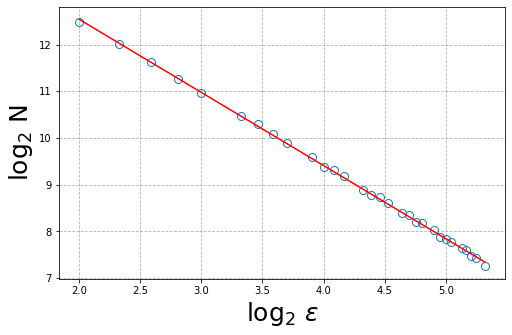

0.01


1.566

In [ ]:

BOX_DIMENSION(dd,1)